# NEST SIMULATION     

## 0. LIBRARIES

### 0.1 Regular Libraries

In [3]:
import nest
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### 0.2 Functions created by me

In [4]:
from getData import *
from plot import *

### 1. IMPORTING DATA

In [3]:
positions_list = getNeuronPositions('net_10000')

synaptic_matrix = getSynapses('net_10000')

input_matrix = getInput('net_10000', 10000)

neuron_IDs = getNeuronMatrix('net_10000')

## 2. CREATING THE NEST NETWORK

### 2.1 Creating the Neurons

**All the neurons have the same characteristics. They are all alpha conductance based integrate and fire model, with the default parameters of nest.**

Here we create a position list, with the coordinates of each neuron of the network.
(This first step is not necessary, since the spatial distribution of the network does not influence the NEST simulation.)

In [4]:
pos = nest.spatial.free(positions_list) # using NEURON positions

In [5]:
s_nodes = nest.Create("iaf_cond_alpha", 9999, positions=pos) 

### 2.2 Connecting the Network

In this version of the simulation **each connected pair has 1 synapses, and all synapses have a weight of -1 x cond x N\***
With the info of the synaptic matrix, we create the pre-synaptic as post-synaptic neuron ID lists, and transform them into numpy arrays

\* N = the # corresponding to their connection on neuron

cond = a value drawn from the conductance distribution used on neuron. (each type of source neuron has a different distribution)

In [6]:
'''pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes[synaptic_matrix[i][0]])
    pos_list.append(s_nodes[synaptic_matrix[i][1]])
    
pre_array = np.transpose(np.array(pre_list)).flatten()
pos_array = np.transpose(np.array(pos_list)).flatten()'''

'pre_list = []\npos_list = []\n\nfor i in range(0,len(synaptic_matrix)):\n    pre_list.append(s_nodes[synaptic_matrix[i][0]])\n    pos_list.append(s_nodes[synaptic_matrix[i][1]])\n    \npre_array = np.transpose(np.array(pre_list)).flatten()\npos_array = np.transpose(np.array(pos_list)).flatten()'

With the arrays ready, we can connect the synapses all in one command.
(again here, if we wish to have different parameters and arguments for each synapse, a more complex solution is necessary.)

In [7]:
#syn_matrix = old_getWeightedSynapses(pre_array,pos_array)

In [8]:
#np.savetxt('syn_matrix_10k.csv', syn_matrix, delimiter=',')

In [9]:
syn_matrix = np.loadtxt('/home/ubuntu/BasalGanglia/NEURON-data/net_10000/syn_matrix_10k.csv', delimiter=',')

In [10]:
syn_matrix = syn_matrix.astype(int)

In [11]:
syn_wgt = [] 
conductances = []
for i in range(0,len(syn_matrix)):
    
    neuron_type = neuron_IDs[syn_matrix[i][0]-1][1]
        
    if (neuron_type == 'dspn' or neuron_type == 'ispn' ):
        #"conductance": [2.4e-10, 1e-10]
        cond = np.random.normal(2.4e-10,  1e-10, 1)
        
        if(cond<2.4e-11): #capping at 10% of mean
            cond = 2.4e-11
    elif (neuron_type == 'lts'):
        # conductance mean = 3e-09, std deviation =  0
        cond = 3e-09
        
    elif (neuron_type == 'fs'):
        #"conductance": [1.1e-09, 1.5e-09],
        cond = np.random.normal(1.1e-09, 1.5e-09, 1)
        
        if(cond<1.1e-10): #capping at 10% of mean
            cond = 1.1e-10
    
    conductances.append(cond)    

In [12]:
weights = []
for i in range(0, len(conductances)):
    weights.append(-1*conductances[i]*syn_matrix[i][2])
weights = np.row_stack(weights).flatten()

In [13]:
sources = syn_matrix[:,0]
targets = syn_matrix[:,1]

In [14]:
nest.Connect(sources,targets,conn_spec= "one_to_one", syn_spec= {"weight": weights})

### 2.3 Creating the Input

Now onto the creation of the Spike Generators. **The synapses between the input neurons and the ones on the network all have a weight of 10**

In [15]:
inputs = nest.Create("spike_generator", 10000)

In [16]:
input_matrix.append([0.1])

In [17]:
for g, generator in enumerate(inputs):

    nest.SetStatus(generator, {"spike_times": input_matrix[g]})

In [18]:
input_syn_wgt = np.full(len(inputs), 11.0)
nest.Connect(inputs,s_nodes, conn_spec= "one_to_one", syn_spec={"weight": input_syn_wgt})

### 2.4 Creating the Recording Devices

In [19]:
spikerecorder = nest.Create("spike_recorder")

In [20]:
nest.Connect(s_nodes,spikerecorder, conn_spec= "all_to_all")

In [21]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"])
nest.Connect(multimeter,s_nodes, "all_to_all")

In [22]:
mult1 = nest.Create("multimeter", 5)
mult1.set(record_from=["V_m"])
chosen_nodes = [1,11,21,31,41]
nest.Connect(mult1,chosen_nodes, "one_to_one")

## 3. RUNNING THE SIMULATION
Here we are using a total run itme of 2000 ms (and the default step of simulation of 0.1 ms)

In [23]:
nest.Simulate(2000.0)


Nov 20 22:29:33 NodeManager::prepare_nodes [Info]: 
    Preparing 20007 nodes for simulation.

Nov 20 22:29:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 20007
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Nov 20 22:31:07 SimulationManager::run [Info]: 
    Simulation finished.


## 4. ANALYSING THE RESULTS

In [24]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
ids = dmm["events"]["senders"]

In [25]:
for i in range(0,5):
    dmm1 = mult1[i].get()
    Vms1 = dmm1["events"]["V_m"]
    ts1 = dmm1["events"]["times"]
    ids1 = dmm1["events"]["senders"]

In [26]:
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]

In [5]:
chin_color='xkcd:orange'
ispn_color='xkcd:blue purple'
lts_color='xkcd:bright purple'
dspn_color='xkcd:sky blue'
fs_color='xkcd:dark blue'
import matplotlib.ticker as ticker


def ComputeFiringRatesNEST(senders, times, neuron_IDs):

    dspn_spks = []
    ispn_spks = []
    lts_spks = []
    chin_spks = []
    fs_spks = []
    
    dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_IDs)


    for i in range(0, len(senders)):
        if senders[i] in dspn_ID:
            dspn_spks.append(times[i])
        elif senders[i] in ispn_ID:
            ispn_spks.append(times[i])
        elif senders[i] in chin_ID:
            chin_spks.append(times[i])
        elif senders[i] in lts_ID:
            lts_spks.append(times[i])
        elif senders[i] in fs_ID:
            fs_spks.append(times[i])

    dspn_spikes_dt = []
    ispn_spikes_dt = []
    chin_spikes_dt = []
    lts_spikes_dt = []
    fs_spikes_dt = []

    for d_time in range (0, 1981, 20):

        start = d_time
        stop = d_time + 20
        spikes_dt_aux = [0,0,0,0,0]

        for elem in dspn_spks:
            if (start < elem <= stop):
                spikes_dt_aux[0] +=1
        for elem in ispn_spks:
            if (start < elem <= stop):
                spikes_dt_aux[1] +=1
        for elem in chin_spks:
            if (start < elem <= stop):
                spikes_dt_aux[2] +=1
        for elem in lts_spks:
            if (start < elem <= stop):
                spikes_dt_aux[3] +=1
        for elem in fs_spks:
            if (start < elem <= stop):
                spikes_dt_aux[4] +=1

        dspn_spikes_dt.append(spikes_dt_aux[0])
        ispn_spikes_dt.append(spikes_dt_aux[1])
        chin_spikes_dt.append(spikes_dt_aux[2])
        lts_spikes_dt.append(spikes_dt_aux[3])
        fs_spikes_dt.append(spikes_dt_aux[4])
        
    N_dspn = len(dspn_ID)
    N_ispn = len(ispn_ID)
    N_chin = len(chin_ID)
    N_lts= len(lts_ID)
    N_fs = len(fs_ID)

    dspn_fr = []
    ispn_fr = []
    chin_fr = []
    lts_fr = []
    fs_fr = []

    for elem in dspn_spikes_dt:
        dspn_fr.append(elem*50/(N_dspn))
    for elem in ispn_spikes_dt:
        ispn_fr.append(elem*50/(N_ispn))
    for elem in chin_spikes_dt:
        chin_fr.append(elem*50/(N_chin))
    for elem in lts_spikes_dt:
        lts_fr.append(elem*50/(N_lts))
    for elem in fs_spikes_dt:
        fs_fr.append(elem*50/(N_fs))

    time = []
    for d_time in range (0, 1981, 20):
        time.append(d_time)

    return(time, dspn_fr, ispn_fr, chin_fr, lts_fr, fs_fr)

def plotFRNEST(senders, times, neuron_IDs):
    
    time, dspn_fr, ispn_fr, chin_fr, lts_fr, fs_fr = ComputeFiringRatesNEST(senders, times, neuron_IDs)
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axes.xaxis.set_visible(False)
    plt.ylim(0, 20)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    plt.step(time, lts_fr, color = lts_color, linewidth=0.5)
    plt.step(time, chin_fr, color = chin_color, linewidth=0.5)
    plt.step(time, fs_fr, color = fs_color, linewidth=0.5)
    plt.step(time, dspn_fr, color = dspn_color, linewidth=1)
    plt.step(time, ispn_fr, color = ispn_color, linewidth=1)
    
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(' Firing Rate [Hz]')

    plt.show()
    
    #------------------------------------------------------------#
    fig1 = plt.figure()
    ax1 = fig1.add_axes([0,0,1,1])
    ax1.axes.xaxis.set_visible(False)
    plt.ylim(0, 20)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
   
    plt.step(time, lts_fr, color = lts_color, linewidth=0.5)
    plt.step(time, chin_fr, color = chin_color, linewidth=0.5)
    plt.step(time, fs_fr, color = fs_color, linewidth=0.5)
    
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel(' Firing Rate [Hz]')
    
    plt.show()
    
    #------------------------------------------------------------#    
    fig2 = plt.figure()
    ax2 = fig2.add_axes([0,0,1,1])
    ax2.axes.xaxis.set_visible(False)
    plt.ylim(0, 15)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))    
    plt.step(time, dspn_fr, color = dspn_color, linewidth=1)
    plt.step(time, ispn_fr, color = ispn_color, linewidth=1)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel(' Firing Rate [Hz]')
    
    plt.show()
    
    return

def RasterNEST(evs,ts, neuron_IDs):
    spikes = {}
    for i in range(0, len(evs)) :

        nID = evs[i]
        spike_time = ts[i]
        if(nID not in spikes.keys()):
            spikes[nID] = []            
        spikes[nID].append(spike_time)

    for i in range(0, 10000):
        if(i not in spikes.keys()):
            spikes[i] = []

    n_ids = np.array(list(spikes.keys()), dtype=int)
    n_ids.sort() #organize the neurons by id

    dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_IDs)

    orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


    fig_handle = plt.figure()
    fig, ax = plt.subplots(1,1)
    ax = fig_handle.add_subplot(111)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
    ax.set_xlabel('$t$ (ms)')
    ax.axes.yaxis.set_visible(False)


    plotSpikes(spikes, fs_ID, orderedIDs, fs_color, 'fs', ax)
    plotSpikes(spikes, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
    plotSpikes(spikes, lts_ID, orderedIDs, lts_color, 'lts', ax)
    plotSpikes(spikes, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
    plotSpikes(spikes, chin_ID, orderedIDs, chin_color, 'chin', ax)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    # Put a legend to the right of the current axis

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return()

def plotSpikes(events, id_array, raster_order, color, label, ax):
    
    label_done = False
    
    for neuron_id in id_array:
        
        spikes = events[neuron_id] #array of the spike times of neuron i
        
        index = raster_order.index(neuron_id)
        if not label_done:
            ax.plot(spikes, np.full_like(spikes, index), ms = 1, marker=".", label=label, color=color, linestyle="None")

            #this full_like function generates an array that has the same size as events[i], with the value index
            #on every position (so we #have the same number of x and ys for plotting)
            label_done = True
        else:
            ax.plot(spikes, np.full_like(spikes, index), ms = 1, marker=".", color=color, linestyle="None")
    return()

In [6]:
evs = np.loadtxt('/home/ubuntu/BasalGanglia/evs_G3_w11.csv', delimiter=',')
ts = np.loadtxt('/home/ubuntu/BasalGanglia/ts_G3_w11.csv', delimiter=',')
neuron_IDs = getNeuronMatrix('net_10000')

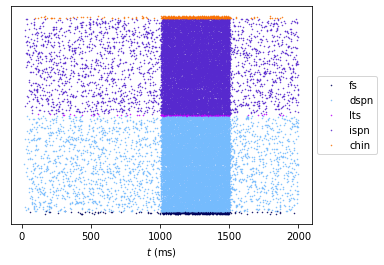

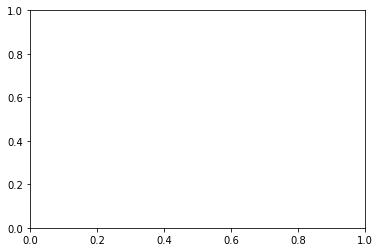

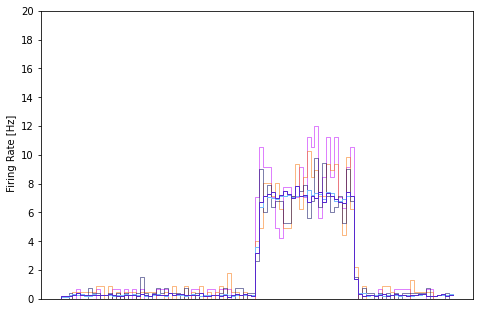

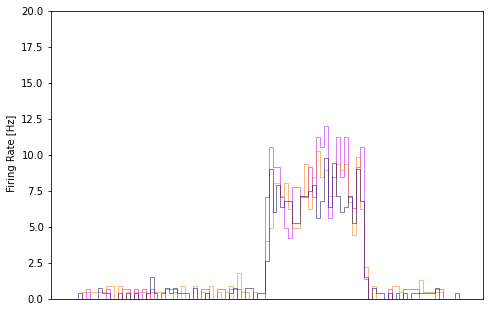

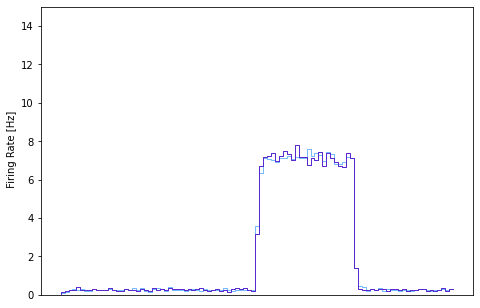

In [7]:
RasterNEST(evs, ts , neuron_IDs)

plotFRNEST(evs, ts, neuron_IDs)

### OTHERS